In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [2]:
train_df= pd.read_csv("train.csv")
test_df= pd.read_csv("test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


In [6]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [7]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [8]:
# extracting and then removing the targets from the training data 
targets = train_df['Survived']
train_df.drop(['Survived'], 1, inplace=True)

D:\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
combined = train_df.append(test_df)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

In [10]:
#Now let's map the title can bin them
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [11]:
#Generate a new Title column
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined['Title'] = combined['Title'].map(Title_Dictionary)


In [12]:
#let's get the median age based on people's gender, Pclass and Title
fill_mean = lambda g: g.fillna(g.mean())
combined['Age'] = combined.groupby(['Sex', 'Title', 'Pclass'])['Age'].apply(fill_mean)

In [13]:
# Name can be dropped now
combined.drop('Name', axis=1, inplace=True)

In [14]:
# removing the title variable
combined.drop('Title', axis=1, inplace=True)

In [15]:
# removing the Cabin variable
combined.drop('Cabin', axis=1, inplace=True)

In [16]:
# removing the Ticket variable
combined.drop('Ticket', axis=1, inplace=True)

In [17]:
#Fill out the missing fare data
combined['Fare'].fillna(combined['Fare'].mean(), inplace=True)

In [18]:
# two missing embarked values - filling them with the most frequent one in the train set
combined['Embarked'].fillna('S', inplace=True)

In [19]:
# encoding in dummy variable
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)

In [20]:
# mapping gender to numerical one 
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})


In [21]:
# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1


In [34]:
combined

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,3,1,22.00000,1,0,7.2500,0,0,1,2
1,1,0,38.00000,1,0,71.2833,1,0,0,2
2,3,0,26.00000,0,0,7.9250,0,0,1,1
3,1,0,35.00000,1,0,53.1000,0,0,1,2
4,3,1,35.00000,0,0,8.0500,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1304,3,1,28.31891,0,0,8.0500,0,0,1,1
1305,1,0,39.00000,0,0,108.9000,1,0,0,1
1306,3,1,38.50000,0,0,7.2500,0,0,1,1
1307,3,1,28.31891,0,0,8.0500,0,0,1,1


In [22]:
#Prepare the training dataset
df_im_input=combined.iloc[:891]
df_im_output=targets

In [23]:
#build Logistic Regression Model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(df_im_input,targets)

D:\Anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [24]:
#Let’s first test our training dataset prediction accuracy
#get predictions based on training input
preds=logreg.predict(df_im_input)
preds_probabilities = logreg.predict_proba(df_im_input)


In [25]:
#preds_probabilities has two numbers for each row of features: [probability of false, probability of true]
preds_probabilities.shape

(891, 2)

In [26]:
#just need one as they can be calcualted using 1- other
pred_probs = preds_probabilities[:, 1]


In [27]:
from sklearn.metrics import roc_curve, auc
#roc_curve() returns a list of false positive rates (FPR) and true positives rates (TPR) for different configurations of the classifier used to plot the ROC.
[fpr, tpr, thr] = roc_curve(targets, pred_probs)


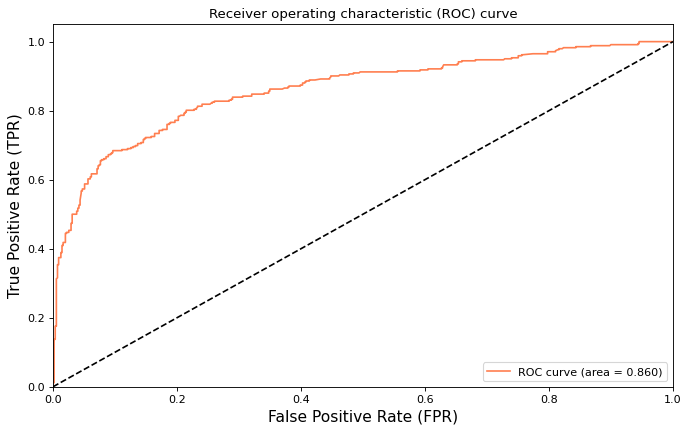

In [28]:
#plot ROC curve
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [29]:
#check model accuracy on training dataset
from sklearn.metrics import confusion_matrix, accuracy_score
print("accuracy: %2.3f" % accuracy_score(targets, preds))
print("AUC: %2.3f" % auc(fpr, tpr))

accuracy: 0.804
AUC: 0.860


In [30]:
#confusion matrix can give us the number of true positives, false positives, true negatives, and false negatives.
conf_m=confusion_matrix(targets, preds)

In [31]:
conf_m

array([[478,  71],
       [104, 238]], dtype=int64)

In [32]:
#get the test input and predictions
df_test_input=combined.iloc[891:]
df_test_preds=logreg.predict(df_test_input)

In [33]:
#output the results to a csv file
submit = pd.DataFrame()
test = pd.read_csv('test.csv')
submit['PassengerId'] = test['PassengerId']
submit['Survived'] = df_test_preds
submit.to_csv('Titanic_LR.csv', index=False)

In [35]:
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [38]:
import random
random.randrange(combined.shape[0])

1182

In [110]:
X_train=combined.iloc[:891]
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,3,1,22.000000,1,0,7.2500,0,0,1,2
1,1,0,38.000000,1,0,71.2833,1,0,0,2
2,3,0,26.000000,0,0,7.9250,0,0,1,1
3,1,0,35.000000,1,0,53.1000,0,0,1,2
4,3,1,35.000000,0,0,8.0500,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,0,0,1,1
887,1,0,19.000000,0,0,30.0000,0,0,1,1
888,3,0,17.360874,1,2,23.4500,0,0,1,4
889,1,1,26.000000,0,0,30.0000,1,0,0,1


In [114]:
X_train["Target"]=targets

D:\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
k=100
test=[]
train=[]
n= int(X_train.shape[0]/k)
index=list(range(X_train.shape[0]))

for kk in range(k):
    train_index=list(range(X_train.shape[0]))
    test_index=random.sample(index, n)
    for i in test_index:
        index.remove(i)
    for i in test_index:
        train_index.remove(i)

    test.append(X_train.iloc[test_index])
    train.append(X_train.iloc[train_index])

In [116]:
test[0]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Target
34,1,1,28.00000,1,0,82.1708,1,0,0,2,0
583,1,1,36.00000,0,0,40.1250,1,0,0,1,0
517,3,1,28.31891,0,0,24.1500,0,1,0,1,0
777,3,0,5.00000,0,0,12.4750,0,0,1,1,1
630,1,1,80.00000,0,0,30.0000,0,0,1,1,1
654,3,0,18.00000,0,0,6.7500,0,1,0,1,0
810,3,1,26.00000,0,0,7.8875,0,0,1,1,0
107,3,1,28.31891,0,0,7.7750,0,0,1,1,1


In [117]:
test[1]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Target
303,2,0,20.717083,0,0,12.3500,0,1,0,1,1
640,3,1,20.000000,0,0,7.8542,0,0,1,1,0
735,3,1,28.500000,0,0,16.1000,0,0,1,1,0
115,3,1,21.000000,0,0,7.9250,0,0,1,1,0
314,2,1,43.000000,1,1,26.2500,0,0,1,3,0
730,1,0,29.000000,0,0,211.3375,0,0,1,1,1
88,1,0,23.000000,3,2,263.0000,0,0,1,6,1
175,3,1,18.000000,1,1,7.8542,0,0,1,3,0


In [130]:
train[0].iloc[:,:-1]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,3,1,22.000000,1,0,7.2500,0,0,1,2
1,1,0,38.000000,1,0,71.2833,1,0,0,2
2,3,0,26.000000,0,0,7.9250,0,0,1,1
3,1,0,35.000000,1,0,53.1000,0,0,1,2
4,3,1,35.000000,0,0,8.0500,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,0,0,1,1
887,1,0,19.000000,0,0,30.0000,0,0,1,1
888,3,0,17.360874,1,2,23.4500,0,0,1,4
889,1,1,26.000000,0,0,30.0000,1,0,0,1


In [131]:
train[0].iloc[:,-1]

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Target, Length: 883, dtype: int64

In [132]:
#Prepare the training dataset
df_im_input=train[0].iloc[:,:-1]
df_im_output=train[0].iloc[:,-1]

In [133]:
logreg = LogisticRegression()
logreg.fit(df_im_input,df_im_output)

D:\Anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [135]:
#Let’s first test our training dataset prediction accuracy
#get predictions based on training input
preds=logreg.predict(df_im_input)
preds_probabilities = logreg.predict_proba(df_im_input)
pred_probs = preds_probabilities[:, 1]
[fpr, tpr, thr] = roc_curve(df_im_output, pred_probs)
auc(fpr, tpr)

0.8638404476834982

In [136]:
accuracy_score(df_im_output, preds)

0.812004530011325